# Notebook for analysing pipeline results

Importing libraries:

In [41]:
import os
import glob
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
import nistats
import scipy
import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nilearn.regions import RegionExtractor
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from scipy.stats import norm

In [20]:
from logger import Logger
from utils import read_yaml, check_folder, fetch_masker, possible_subjects_id, get_subject_name

Some useful functions:

In [21]:
def fetch_map(path, distribution_name):
    path = os.path.join(path, '*' + distribution_name+'.nii.gz')
    files = sorted(glob.glob(path))
    return files

In [ ]:
def load_atlas(name='cort-prob-2mm'):
    atlas = datasets.fetch_atlas_harvard_oxford(name)
    labels = atlas['labels']
    maps = nilearn.image.load_img(atlas['maps'])
    return maps, labels

In [22]:
def batchify(x, y, size=10):
    if len(x) != len(y):
        raise ValueError('vector length mismatch')
    m = len(x)
    x_batch = []
    y_batch = []
    last = 0
    for i in range(m//size):
        x_batch.append(x[last:last+size])
        y_batch.append(y[last:last+size])
        last = last+size
    x_batch.append(x[last:])
    y_batch.append(y[last:])
    return zip(x_batch, y_batch)

Defining variables:

In [23]:
language = 'english'

In [24]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_{language}"
SMOOTHED_MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/smoothed_global_masker_{language}"

Defining objects:

In [25]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

In [26]:
masker = fetch_masker(MASKER_PATH, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
smoothed_masker = fetch_masker(SMOOTHED_MASKER_PATH, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

### Determination of the hrf for the following analysis

In [54]:
hrf_list = [
    'spm', # hrf model used in SPM
    'spm + derivative', # SPM model plus its time derivative (2 regressors)
    'spm + derivative + dispersion', # idem, plus dispersion derivative (3 regressors)
    'glover', # this one corresponds to the Glover hrf
    'glover + derivative', # the Glover hrf + time derivative (2 regressors)
    'glover + derivative + dispersion' # idem + dispersion derivative
]
subject_list = [57, 63, 67, 77] # identified correct subjects
model_name = 'bert-base-cased'
hidden_layer_list = [[1], [6], [8], [9], [10], [12]]
attention_layer_head_list = [[7, 6], [4, 10], [8, 1], [8,2], [6,7], [8, 10], [8, 11], [9, 6]]

In [28]:
reg_model_names = ['attention-layer-{}_head-{}'.format(layer, head) for hrf in hrf_list for subject in subject_list for (layer, head) in attention_layer_head_list ]
reg_model_names += ['hidden-layer-{}'.format(hidden_layers[0]) for hrf in hrf_list for subject in subject_list for hidden_layers in hidden_layer_list]


#### R2

In [29]:
distribution_name = 'R2'


    ##############################################################################
    ###################         HRF spm        ###################
    max: 0.2599216293039259
    75%: 0.008868061679319427
    median: 0.0004870379290168993
    mean: 0.008245440711537674
    25%: -0.0009432293895007395
    min: -8.608776142681336
    
    Data > 0.2: 0.006301956894614841
    Data > 0.15: 0.11418871894916238
    Data > 0.1: 0.7835661404075996
    Data > 0.05: 4.487952302406252
    
    ##############################################################################
    


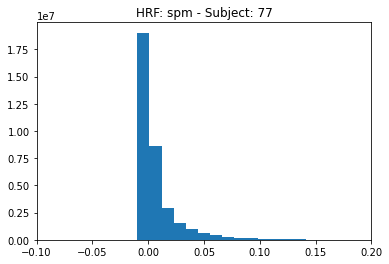


    ##############################################################################
    ###################         HRF spm + derivative        ###################
    max: 0.2806225481374186
    75%: 0.009290241862852456
    median: 0.000952237169993554
    mean: 0.008792892282731892
    25%: -0.0008220860145219203
    min: -3.0963193662103223
    
    Data > 0.2: 0.00815144424412137
    Data > 0.15: 0.12425815007425349
    Data > 0.1: 0.8514491760876356
    Data > 0.05: 4.914087887638849
    
    ##############################################################################
    


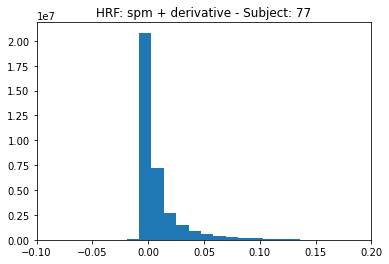


    ##############################################################################
    ###################         HRF spm + derivative + dispersion        ###################
    max: 0.2779681180954616
    75%: 0.009011966102095778
    median: 0.0009273725447779516
    mean: 0.00855674033185519
    25%: -0.0008598987594254185
    min: -6.305062982731245
    
    Data > 0.2: 0.008219943775584574
    Data > 0.15: 0.12186066647304132
    Data > 0.1: 0.8737800233446403
    Data > 0.05: 4.750579506036178
    
    ##############################################################################
    


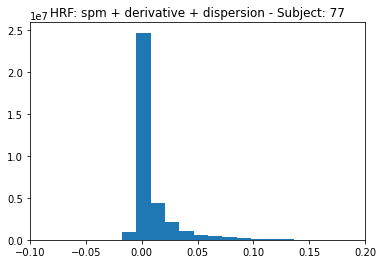

In [49]:
for hrf in hrf_list:
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data = np.hstack([masker.transform(img).reshape(-1) for img in imgs])
    print(f"""
    ##############################################################################
    ###################         HRF {hrf}        ###################
    max: {np.max(data)}
    75%: {np.percentile(data, 75)}
    median: {np.percentile(data, 50)}
    mean: {np.mean(data)}
    25%: {np.percentile(data, 25)}
    min: {np.min(data)}
    
    Data > 0.2: {100*np.sum(data>0.2)/len(data)}
    Data > 0.15: {100*np.sum(data>0.15)/len(data)}
    Data > 0.1: {100*np.sum(data>0.1)/len(data)}
    Data > 0.05: {100*np.sum(data>0.05)/len(data)}
    
    ##############################################################################
    """)
    data[data>1] = np.nan
    data[data<-0.4] = np.nan
    plt.hist(data[~np.isnan(data)], bins=50)
    plt.xlim((-0.1, 0.2))
    plt.title(f"HRF: {hrf}")
    plt.show()


##############################################################################
###################         HRF spm + derivative        ###################
max: 8.608776142681336
75%: 0.001549230584507042
median: 0.00010417790217025972
mean: 0.0005474515711942177
25%: -0.0009882186138779367
min: -3.1076800765959245

Data > 0.2: 0.001301491097800891
Data > 0.15: 0.001301491097800891
Data > 0.1: 0.0017124882865801197
Data > 0.05: 0.037469243710373024

##############################################################################



/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


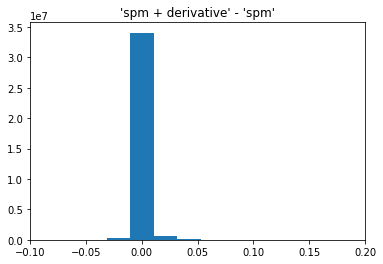

In [51]:
data= []
for hrf in ['spm', 'spm + derivative']: # 2 best identified hrf
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data.append(np.hstack([masker.transform(img).reshape(-1) for img in imgs]))
data = data[1] - data[0]
print(f"""
##############################################################################
###################         HRF {hrf}        ###################
max: {np.max(data)}
75%: {np.percentile(data, 75)}
median: {np.percentile(data, 50)}
mean: {np.mean(data)}
25%: {np.percentile(data, 25)}
min: {np.min(data)}

Data > 0.2: {100*np.sum(data>0.2)/len(data)}
Data > 0.15: {100*np.sum(data>0.15)/len(data)}
Data > 0.1: {100*np.sum(data>0.1)/len(data)}
Data > 0.05: {100*np.sum(data>0.05)/len(data)}

##############################################################################
""")
data[data>1] = np.nan
data[data<-0.4] = np.nan
plt.hist(data[~np.isnan(data)], bins=50)
plt.xlim((-0.1, 0.2))
plt.title("'spm + derivative' - 'spm'")
plt.show()

#### Pearson Coefficient 

In [55]:
distribution_name = 'Pearson_coeff'


    ##############################################################################
    ###################         HRF spm        ###################
    max: 0.5177206425608482
    75%: 0.10935408937988064
    median: 0.05272860980007671
    mean: 0.06821765055714024
    25%: 0.013264488465320832
    min: -0.19634181924787023
    
    Data > 0.2: 7.216083141991309
    Data > 0.15: 14.719727317065152
    Data > 0.1: 28.101590285122448
    Data > 0.05: 51.625425382090384
    
    ##############################################################################
    


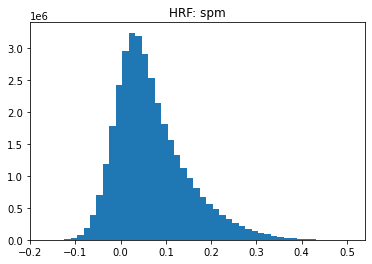


    ##############################################################################
    ###################         HRF spm + derivative        ###################
    max: 0.5339845743135865
    75%: 0.11068743671282957
    median: 0.05375653291149071
    mean: 0.0705422545486214
    25%: 0.015024430965312634
    min: -0.1615176317993926
    
    Data > 0.2: 7.596529539737948
    Data > 0.15: 15.230939320375048
    Data > 0.1: 28.50107955261586
    Data > 0.05: 52.25253859263603
    
    ##############################################################################
    


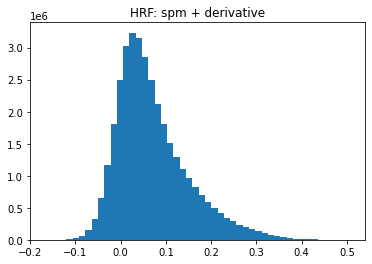


    ##############################################################################
    ###################         HRF spm + derivative + dispersion        ###################
    max: 0.530222279351241
    75%: 0.10970542017042477
    median: 0.052965020720797173
    mean: 0.07012533678257556
    25%: 0.014849196666799763
    min: -0.16155285805527209
    
    Data > 0.2: 7.471380895754673
    Data > 0.15: 15.004548368889157
    Data > 0.1: 28.189817681647057
    Data > 0.05: 51.785919784308675
    
    ##############################################################################
    


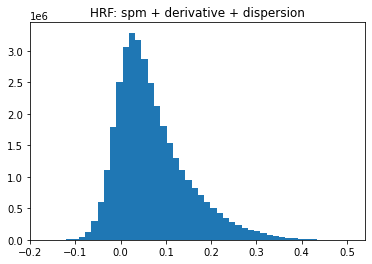


    ##############################################################################
    ###################         HRF glover        ###################
    max: 0.48897802426744175
    75%: 0.10117462198532827
    median: 0.04866590456718021
    mean: 0.0629889273437017
    25%: 0.011608101872994794
    min: -0.17624214333164767
    
    Data > 0.2: 5.8254741537567885
    Data > 0.15: 12.610284245655759
    Data > 0.1: 25.40161275296877
    Data > 0.05: 49.17101867023229
    
    ##############################################################################
    


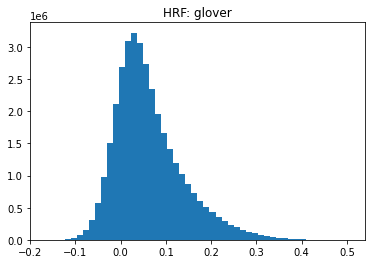


    ##############################################################################
    ###################         HRF glover + derivative        ###################
    max: 0.5115232108275165
    75%: 0.1026669654879825
    median: 0.04980188440204516
    mean: 0.0654211571212044
    25%: 0.013512289317017461
    min: -0.16210154497573864
    
    Data > 0.2: 6.246951770849887
    Data > 0.15: 13.207189162826126
    Data > 0.1: 25.883506956812415
    Data > 0.05: 49.87813933352696
    
    ##############################################################################
    


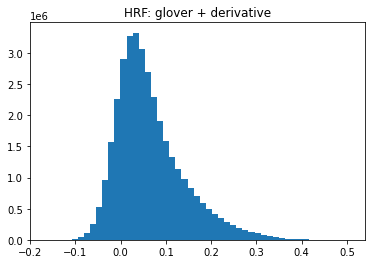


    ##############################################################################
    ###################         HRF glover + derivative + dispersion        ###################
    max: 0.5057571782285276
    75%: 0.10345571793622718
    median: 0.049496402220751606
    mean: 0.06492790853887725
    25%: 0.011924324305782682
    min: -0.16299576333185423
    
    Data > 0.2: 6.2807220398612476
    Data > 0.15: 13.259180307206698
    Data > 0.1: 26.175862957097372
    Data > 0.05: 49.69449208967411
    
    ##############################################################################
    


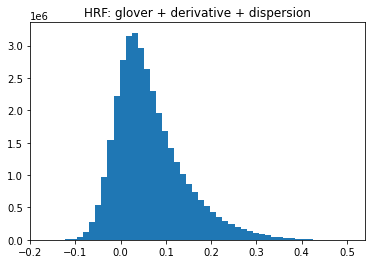

In [57]:
for hrf in hrf_list:
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data = np.hstack([masker.transform(img).reshape(-1) for img in imgs])
    print(f"""
    ##############################################################################
    ###################         HRF {hrf}        ###################
    max: {np.max(data)}
    75%: {np.percentile(data, 75)}
    median: {np.percentile(data, 50)}
    mean: {np.mean(data)}
    25%: {np.percentile(data, 25)}
    min: {np.min(data)}
    
    Data > 0.2: {100*np.sum(data>0.2)/len(data)}
    Data > 0.15: {100*np.sum(data>0.15)/len(data)}
    Data > 0.1: {100*np.sum(data>0.1)/len(data)}
    Data > 0.05: {100*np.sum(data>0.05)/len(data)}
    
    ##############################################################################
    """)
    data[data>1] = np.nan
    data[data<-0.4] = np.nan
    plt.hist(data[~np.isnan(data)], bins=50)
    plt.xlim((-0.2, 0.54))
    plt.title(f"HRF: {hrf}")
    plt.show()


##############################################################################
###################         HRF spm + derivative        ###################
max: 0.1638431133910795
75%: 0.012727405923583054
median: 0.0002137281977143829
mean: 0.0023246039914808082
25%: -0.010369441791048536
min: -0.09171806801510506

Data > 0.2: 0.0
Data > 0.15: 0.00034249765731602397
Data > 0.1: 0.07843196352536949
Data > 0.05: 2.0460810048059273

##############################################################################



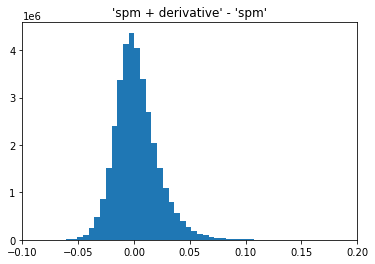

In [59]:
data= []
for hrf in ['spm', 'spm + derivative']: # 2 best identified hrf
    imgs = []
    for subject in subject_list:
        paths = [os.path.join(OUTPUT_PATH, f"sub-0{subject}/{hrf.replace(' ', '')}_{subject}_{model_name}_{name}") for name in reg_model_names]
        imgs += [fetch_map(path, distribution_name)[0] for path in paths]
    data.append(np.hstack([masker.transform(img).reshape(-1) for img in imgs]))
data = data[1] - data[0]
print(f"""
##############################################################################
###################         HRF {hrf}        ###################
max: {np.max(data)}
75%: {np.percentile(data, 75)}
median: {np.percentile(data, 50)}
mean: {np.mean(data)}
25%: {np.percentile(data, 25)}
min: {np.min(data)}

Data > 0.2: {100*np.sum(data>0.2)/len(data)}
Data > 0.15: {100*np.sum(data>0.15)/len(data)}
Data > 0.1: {100*np.sum(data>0.1)/len(data)}
Data > 0.05: {100*np.sum(data>0.05)/len(data)}

##############################################################################
""")
data[data>1] = np.nan
data[data<-0.4] = np.nan
plt.hist(data[~np.isnan(data)], bins=50)
plt.xlim((-0.1, 0.2))
plt.title("'spm + derivative' - 'spm'")
plt.show()

### Bert with sentence-level predictions VS Bert with sequential prediction

In [ ]:
data = {}
model_names = ['bert-base-cased', 'bert-base-cased_sequential']
analysis = {
    'Hidden-layers': 'hidden-layer-\d{1,2}',
    'Attention-layers': 'attention-layer-\d{1,2}',
    'Specific-attention-heads': 'attention-layer-\d{1,2}_head-\d{1,2}'
}

In [ ]:
for model_name in model_names:
    data[model_name] = {}
    for analysis_of_interest in analysis.keys():
        R2_maps = {}
        Pearson_coeff_maps = {}
        for subject_id in possible_subjects_id(language):
            subject = get_subject_name(subject_id)
            path_to_map = os.path.join(OUTPUT_PATH, subject, '_'.join([model_name, subject_id, analysis[analysis_of_interest]]))
            R2_maps[subject] = fetch_map(path_to_map, 'R2')
            Pearson_coeff_maps[subject] = fetch_map(path_to_map, 'Pearson_coeff')
        data[model_name][analysis_of_interest]['models'] = [name.split('_')[-1] for name in list(Pearson_coeff_maps.values())[-1]]
        R2_lists = list(zip(*R2_maps.values()))
        Pearson_coeff_lists = list(zip(*Pearson_coeff_maps.values()))
        for index, model in enumerate(data[model_name][analysis_of_interest]['models']):
            data[model_name][analysis_of_interest][model]['R2'] = R2_lists[index]
            data[model_name][analysis_of_interest][model]['Pearson_coeff'] = Pearson_coeff_lists[index]

In [ ]:
def create_one_sample_t_test(name, maps, output_dir, smoothing_fwhm=None, vmax=None, design_matrix=None):
    """ Do a one sample t-test over the maps.
    """
    if not os.path.isdir(output_dir):
        os.path.mkdir(output_dir)

    model = SecondLevelModel(smoothing_fwhm=smoothing_fwhm)
    design_matrix = design_matrix if design_matrix else pd.DataFrame([1] * len(maps),
                                                             columns=['intercept'])
    model = model.fit(maps,
                      design_matrix=design_matrix)
    z_map = model.compute_contrast(output_type='z_score')
    nib.save(z_map, os.path.join(output_dir, "{}_group_zmap.nii.gz".format(name)))

    p_val = 0.001
    z_th = norm.isf(p_val)  # 3.09
    display = plotting.plot_glass_brain(
        z_map,
        threshold=z_th,
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=name + ' z values (P<.001 unc.)',
        vmax=10)
    display.savefig(os.path.join(output_dir, "{}_group_zmap".format(name)))

    # apply fdr to zmap
    thresholded_zmap, th = map_threshold(stat_img=z_map,
                                         alpha=0.01,
                                         height_control='fdr',
                                         cluster_threshold=0)
    nib.save(thresholded_zmap, os.path.join(output_dir, "{}_group_fdr_zmap.nii.gz".format(name)))


    display = plotting.plot_glass_brain(
        thresholded_zmap,
        #threshold=np.max([th, z_th]),
        threshold=th,
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=name + ' z values (Pfdr<.01: Z >{}'.format(np.round(th,2)),
        vmax=10)
    display.savefig(os.path.join(output_dir, "{}_fdr_group_zmap".format(name)))

    # effect size-map
    eff_map = model.compute_contrast(output_type='effect_size')
    nib.save(eff_map, os.path.join(output_dir, "{}_group_effect.nii.gz".format(name)))

    display = plotting.plot_glass_brain(
        smooth_img(eff_map, fwhm=6),
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=None, vmax=vmax)
    display.savefig(os.path.join(output_dir, "{}_group_effect".format(name)))

    #thr = thresholded_zmap.get_data()
    thr = np.abs(z_map.get_data())
    eff = eff_map.get_data()
    thr_eff = eff * (thr > 3.09)
    eff_thr_map = new_img_like(eff_map, thr_eff)

    nib.save(eff_thr_map, os.path.join(output_dir, "{}_group_fdr_effect.nii.gz".format(name)))

    display = plotting.plot_glass_brain(
        smooth_img(eff_thr_map, fwhm=6),
        colorbar=True,
        plot_abs=False,
        display_mode='lzry',
        title=None,
        vmax=vmax)
    display.savefig(os.path.join(output_dir, 'group_fdr_effect', "{}_group_fdr_effect".format(name)))


In [ ]:
for model_name in model_names:
    for analysis_of_interest in analysis.keys():
        for key in tqdm(data[model_name][analysis_of_interest].keys()):
            imgs = data[model_name][analysis_of_interest][key]['R2']
            name = '_'.join([model_name, key])
            output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
            check_folder(output_dir)
            create_one_sample_t_test(name, imgs, output_dir, smoothing_fwhm=5.0, vmax=None)

Group analysis of the difference between the models:

In [ ]:
for analysis_of_interest in analysis.keys():
    for key in tqdm(data[model_name][analysis_of_interest].keys()):
        imgs = [data[model_name][analysis_of_interest][key]['R2'] for model_name in model_names]
        imgs = [item for l in imgs for item in l]
        name = '_'.join(['Bert-VS-Bert_sequential', key])
        output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
        check_folder(output_dir)
        design_matrix = pd.concat([pd.DataFrame([1] * len(imgs)/2, columns=['intercept']),
                                   pd.DataFrame([-1] * len(imgs)/2, columns=['intercept'])],
                                  axis=0)
        create_one_sample_t_test(name, imgs, output_dir, smoothing_fwhm=5.0, vmax=None, design_matrix=design_matrix)

In [ ]:
#imgs = []
#for img1, img2 in zip(files1, files2):
#    i1 = nibabel.load(img1)
#    i2 = nibabel.load(img2)
#    imgs.append(new_img_like(i1, i1.get_data() - i2.get_data()))
#
#
#vmax= None
#create_one_sample_t_test(name, imgs, output_dir, smoothing_fwhm=5.0, vmax=vmax)


### Attention heads analysis

### Impact of fine-tuning